In [1]:
from dataloader import DAVIS_Seq2, normalize_image
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [2]:
data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)

batch_size = 10
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

Text(0.5, 1.0, 'Curr Frame')

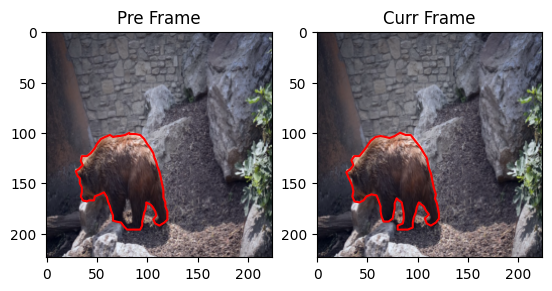

In [4]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [5]:
model = Model()

In [6]:
def chamer_distance_loss(x, y):
    def my_chamfer_distance(x, y):
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        dist = torch.sum((x - y) ** 2, dim=-1)
        dist1 = torch.min(dist, dim=1)[0]
        dist2 = torch.min(dist, dim=0)[0]
        return torch.mean(dist1) + torch.mean(dist2)
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

In [7]:
pre_boundary.shape, curr_boundary.shape

(torch.Size([10, 80, 2]), torch.Size([10, 80, 2]))

In [8]:
def order_loss(x: torch.Tensor, y: torch.Tensor):
    def my_order_loss(x, y):
        min_loss = (x - y).abs().sum()
        for shift in range(1, x.shape[0]):
            loss = (x - torch.roll(y, shifts=shift, dims=0)).abs().sum()
            min_loss = torch.min(min_loss, loss)
        return min_loss
        

    my_order_loss(x[0], y[0])
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_order_loss(x[i], y[i])

    return result / x.shape[0]
order_loss(pre_boundary, curr_boundary)

tensor(380.2000)

In [9]:
torch.cuda.empty_cache()

In [10]:
output = model(pre_frame, curr_frame, pre_boundary)
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(10.3624, grad_fn=<DivBackward0>)

In [31]:
model = Model().to('cuda')
# model_name = "uniform_model"
model_name = "simplify_model"
if model_name == "uniform_model":
    data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
else:
    data_set = DAVIS_Seq2(is_uniform=False, is_one_video=True)

# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 17
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [32]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

3.023008346557617

In [33]:
dict_loss = {}
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-5)
gradient_clip = 1
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
for e in range(num_epochs):
    model.train()
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = loss_func(predic_boundary, curr_boundary.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
    dict_loss[e] = loss.item()
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {loss.item()}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]


Epoch 1, Loss: 688.7877197265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 2, Loss: 767.1544799804688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


Epoch 3, Loss: 620.1690673828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


Epoch 4, Loss: 689.6024169921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 5, Loss: 731.219970703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 6, Loss: 654.8087768554688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 7, Loss: 700.2561645507812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 8, Loss: 720.584228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 9, Loss: 658.1926879882812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 10, Loss: 592.1255493164062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 11, Loss: 600.4509887695312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 12, Loss: 646.0377807617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 13, Loss: 605.1600952148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 14, Loss: 749.697265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 15, Loss: 692.5463256835938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 16, Loss: 772.2265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 17, Loss: 731.84326171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 18, Loss: 664.8346557617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 19, Loss: 636.1511840820312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 20, Loss: 649.55322265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 21, Loss: 669.84375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 22, Loss: 592.9500122070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 23, Loss: 687.7060546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 24, Loss: 747.744140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 25, Loss: 691.9812622070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 26, Loss: 612.8432006835938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]


Epoch 27, Loss: 757.299560546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 28, Loss: 646.0476684570312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


Epoch 29, Loss: 644.2523803710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


Epoch 30, Loss: 678.3032836914062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]


Epoch 31, Loss: 778.796142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 32, Loss: 673.0509033203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 33, Loss: 645.015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


Epoch 34, Loss: 706.5731811523438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.45s/it]


Epoch 35, Loss: 714.95947265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 36, Loss: 731.145263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 37, Loss: 726.836181640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 38, Loss: 651.7560424804688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


Epoch 39, Loss: 743.3925170898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 40, Loss: 729.0243530273438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.45s/it]


Epoch 41, Loss: 689.1688232421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 42, Loss: 689.1227416992188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.45s/it]


Epoch 43, Loss: 634.5170288085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


Epoch 44, Loss: 571.6414184570312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 45, Loss: 705.6831665039062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 46, Loss: 645.5661010742188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch 47, Loss: 635.8683471679688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 48, Loss: 702.70068359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


Epoch 49, Loss: 686.6851806640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]

Epoch 50, Loss: 660.7435913085938


In [34]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

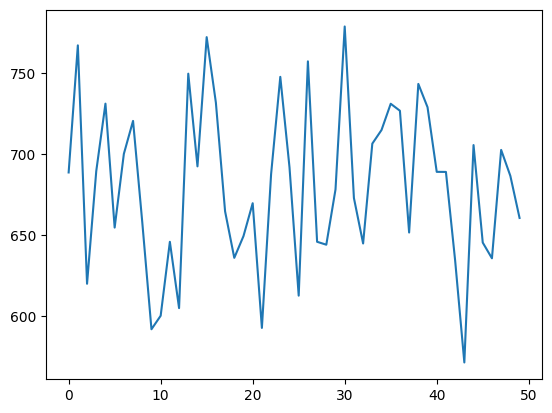

In [35]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [39]:
model = Model()
# model_name = "uniform_model"
model_name = "simplify_model"
loss_name = "order_loss"
# loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

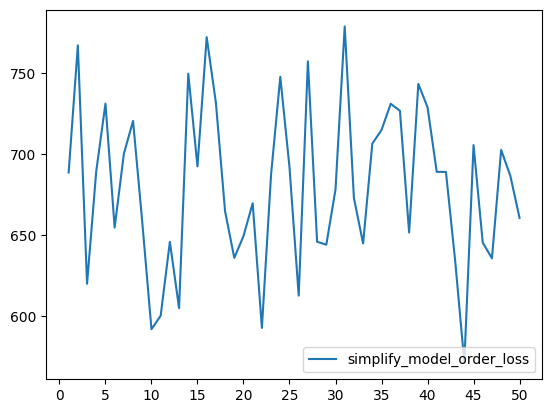

In [40]:
# load the loss
with open(f"./log/{model_name}_{loss_name}.json", "r") as f:
    dict_loss = json.load(f)
# plot the loss
plt.plot(np.array(list(dict_loss.keys())).astype(int) + 1, list(dict_loss.values()), label=f"{model_name}_{loss_name}")
plt.legend(loc="lower right")
# set the xticks
plt.xticks(np.arange(0, 51, 5))
plt.show()

In [2]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 36.06it/s]


0.6565291550408101

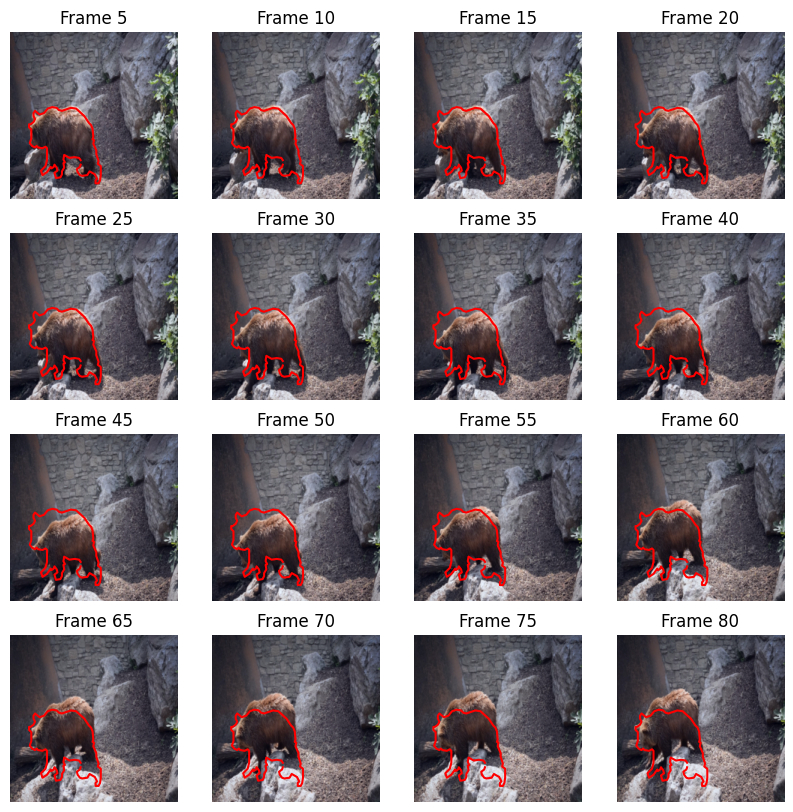

In [42]:
def test_model_one_video(model, test_dataset: DAVIS_test, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 5
    plt.figure(figsize=(10, 10))
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            # pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            # pre_boundary = boundary.squeeze(0).to(device)
            pre_img = img
            if i % interval == 0:
                plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
if model_name == "uniform_model":
    test_dataset = DAVIS_test("bear", is_uniform=True)
else:
    test_dataset = DAVIS_test("bear", is_uniform=False)
test_model_one_video(model, test_dataset)